# Battle of neighbourhood


Here, I want to convert addresses  their equivalent latitude and longitude values. I use the Foursquare API to explore neighborhoods in Toronto , use the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. 

I use the k-means clustering algorithm to complete this task. Finally, I use the Folium library to visualize the neighborhoods in Toronto City and their emerging clusters.

This work is organized as:

#### 1. Download and Explore Dataset
#### 2. Explore Neighborhoods in Toronto
#### 3. Analyze Each Neighborhood
#### 4. Cluster Neighborhoods
#### 5. Examine Clusters


In [36]:
import sys
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install wget

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [37]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/Users/manashsarma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 43.653963, -79.387207.


# 1. Download and Explore Dataset

## This is actually a repeat step of last note book where a constructed a dataframe of 5 (3+2) columns after combining two dataframes from wikipedia 'Toronto postal code' table and related geospatial data table 

In [38]:
geo_df = pd.read_csv('https://cocl.us/Geospatial_data')
geo_df.head()
import requests
post_codes_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
from bs4 import BeautifulSoup
soup = BeautifulSoup(post_codes_url,'lxml')

# extract data
codes_list=[]
borough_list=[]
neighborhood_list=[]

i=1
for x in soup.table.find_all('td'):
    if i == 1:
        codes_list.append(x.text)
    if i == 2:
        borough_list.append(x.text)
    if i == 3: 
        neighborhood_list.append(x.text)
    i = i+1
    if i==4:
        i=1
    
df = pd.DataFrame(columns=['Postalcode','Borough','Neighborhood'])
df['Postalcode'] = codes_list
df['Borough'] = borough_list
df['Neighborhood'] = neighborhood_list

#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned
indexs = df[df['Borough']=="Not assigned"].index
df.drop(indexs, inplace=True)

# Also remove newlines
df['Neighborhood'] = df.Neighborhood.str.replace("\n","")
df = df.reset_index(drop=True)

df_modified = df.groupby(['Postalcode','Borough'])['Neighborhood'].apply(','.join).reset_index()

df_modified.head()
df_merged = pd.concat([df_modified, geo_df], axis = 1).drop('Postal Code', axis=1)

df_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [338]:
df_merged.dtypes.sort_values()

Latitude        float64
Longitude       float64
Postalcode       object
Borough          object
Neighborhood     object
dtype: object

### create map of Toronto using latitude and longitude values

In [398]:
import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Borough'], df_merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Now, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

### Define Foursquare Credentials and Version

In [40]:
CLIENT_ID = 'SH1AMXRLSPUIOCPWD3TNLOSU1L2EW02RGV24FVWG5SBFIRDJ' # your Foursquare ID
CLIENT_SECRET = 'QCGEQAGXKLXCZ2L1PWGGUBHYFIU43BYJN0UOHJY1X2O4E1Z0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SH1AMXRLSPUIOCPWD3TNLOSU1L2EW02RGV24FVWG5SBFIRDJ
CLIENT_SECRET:QCGEQAGXKLXCZ2L1PWGGUBHYFIU43BYJN0UOHJY1X2O4E1Z0


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [41]:
df_merged.loc[0, 'Neighborhood']

'Rouge,Malvern'

Get the neighborhood's latitude and longitude values.

In [42]:
neighborhood_latitude = df_merged.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_merged.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_merged.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge,Malvern are 43.806686299999996, -79.19435340000001.


### Now, let's get the top 100 venues twithin a radius of 1000 meters OR 1 Kilometers.

Let us define URL etc.

In [51]:
#https://developer.foursquare.com/docs/resources/categories
Medical_Center_category = '4bf58dd8d48988d104941735'
Medical_doctoroffice_category = '4bf58dd8d48988d177941735'
Medical_hospital_category = '4bf58dd8d48988d196941735'
Medical_urgentcare_category ='56aa371be4b08b9a8d573526'
Medical_medicallab_category ='4f4531b14b9074f6e4fb0103'
Medical_emergencyroom_category ='4bf58dd8d48988d194941735'
Medical_hospitalWard_category = '58daa1558bbb0b01f18ec1f7'
Mental_health_category = '52e81612bcbc57f1066b7a39'

In [73]:
import requests
LIMIT = 100
radius = 2000

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        Medical_Center_category,
        radius, 
        LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=SH1AMXRLSPUIOCPWD3TNLOSU1L2EW02RGV24FVWG5SBFIRDJ&client_secret=QCGEQAGXKLXCZ2L1PWGGUBHYFIU43BYJN0UOHJY1X2O4E1Z0&v=20180605&ll=43.806686299999996,-79.19435340000001&categoryId=4bf58dd8d48988d104941735&radius=2000&limit=100'

Send the GET request and examine the resutls

In [74]:
results = requests.get(url).json()['response']['groups'][0]['items']

In [75]:
def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

### Assumption in below code
#### If there is a hospital or medical center, there will be a medical lab
#### If there is a medical center, there will be emergency center

In [460]:
Count_Medical_Center_category = 0
Count_Medical_doctoroffice_category=0
Count_Medical_hospital_category=0
Count_Medical_urgentcare_category=0
Count_Medical_medicallab_category=0
Count_Medical_emergencyroom_category=0

for item in results:
    
    cat_id = get_categories(item['venue']['categories'])[0][1]
    
    if(cat_id == Medical_Center_category):
        Count_Medical_Center_category = Count_Medical_Center_category + 1
        Count_Medical_medicallab_category = Count_Medical_medicallab_category + 1
        Count_Medical_emergencyroom_category = Count_Medical_emergencyroom_category + 1
        Count_Medical_urgentcare_category = Count_Medical_urgentcare_category + 1
        
    if(cat_id == Medical_hospital_category) or (cat_id == Medical_hospitalWard_category):
        Count_Medical_hospital_category = Count_Medical_hospital_category + 1
        Count_Medical_medicallab_category = Count_Medical_medicallab_category + 1
        Count_Medical_doctoroffice_category = Count_Medical_doctoroffice_category + 1
        
    if(cat_id == Medical_doctoroffice_category):
        Count_Medical_doctoroffice_category = Count_Medical_doctoroffice_category + 1
        
    if(cat_id == Medical_urgentcare_category):
        Count_Medical_urgentcare_category = Count_Medical_urgentcare_category + 1
        
    if(cat_id == Medical_medicallab_category):
        Count_Medical_medicallab_category = Count_Medical_medicallab_category + 1 
        
    if(cat_id == Medical_emergencyroom_category):
        Count_Medical_emergencyroom_category = Count_Medical_emergencyroom_category + 1     
    

In [461]:
# Now count number of health care as per type
print( "Number of medical centers is %d\n" % Count_Medical_Center_category)
print( "Number of doctor offices is %d\n" % Count_Medical_medicallab_category)
print( "Number of hospitals is %d\n" % Count_Medical_hospital_category)
print( "Number of medical labs is %d\n" % Count_Medical_medicallab_category)
print( "Number of emrgency centers is %d\n" % Count_Medical_Center_category)

Number of medical centers is 1

Number of doctor offices is 1

Number of hospitals is 0

Number of medical labs is 1

Number of emrgency centers is 1



And how many venues were returned by Foursquare?


## 2. Explore Neighborhoods in Toronto



In [472]:
def nearbyMedicalCenterStats(names, latitudes, longitudes, radius=2000, limit =100):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        Medical_Center_category,
        radius, 
        limit)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        Count_Medical_Center_category = 0
        Count_Medical_doctoroffice_category=0
        Count_Medical_hospital_category=0
        Count_Medical_urgentcare_category=0
        Count_Medical_medicallab_category=0
        Count_Medical_emergencyroom_category=0

        for item in results:

            cat_id = get_categories(item['venue']['categories'])[0][1]

            if(cat_id == Medical_Center_category):
                Count_Medical_Center_category = Count_Medical_Center_category + 1
                Count_Medical_medicallab_category = Count_Medical_medicallab_category + 1
                Count_Medical_emergencyroom_category = Count_Medical_emergencyroom_category + 1
                Count_Medical_urgentcare_category = Count_Medical_urgentcare_category + 1

            if(cat_id == Medical_hospital_category) or (cat_id == Medical_hospitalWard_category):
                Count_Medical_hospital_category = Count_Medical_hospital_category + 1
                Count_Medical_medicallab_category = Count_Medical_medicallab_category + 1

            if(cat_id == Medical_doctoroffice_category):
                Count_Medical_doctoroffice_category = Count_Medical_doctoroffice_category + 1

            if(cat_id == Medical_urgentcare_category):
                Count_Medical_urgentcare_category = Count_Medical_urgentcare_category + 1

            if(cat_id == Medical_medicallab_category):
                Count_Medical_medicallab_category = Count_Medical_medicallab_category + 1 

            if(cat_id == Medical_emergencyroom_category):
                Count_Medical_emergencyroom_category = Count_Medical_emergencyroom_category + 1
          
        
        venues_list.append(
            [(name, 
            lat, 
            lng, 
            Count_Medical_Center_category,
            Count_Medical_urgentcare_category,  
            Count_Medical_medicallab_category,
            Count_Medical_emergencyroom_category,
            Count_Medical_hospital_category)])
         
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                   'Neighborhood Latitude', 
                   'Neighborhood Longitude', 
                   'Medical Center',
                   'Urgent care',  
                   'Medical Lab',
                   'Medical Emergency',
                   'Hospital']      
    
    return  nearby_venues    

### code below to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [473]:
toronto_venues = nearbyMedicalCenterStats(names=df_merged['Neighborhood'],
                                   latitudes=df_merged['Latitude'],
                                   longitudes=df_merged['Longitude']
                                  )


In [474]:
print(toronto_venues.shape)
toronto_venues

(103, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Medical Center,Urgent care,Medical Lab,Medical Emergency,Hospital
0,"Rouge,Malvern",43.806686,-79.194353,1,1,1,1,0
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,0,0,0,0
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,3,3,4,3,1
3,Woburn,43.770992,-79.216917,6,6,8,7,2
4,Cedarbrae,43.773136,-79.239476,6,6,6,7,0
5,Scarborough Village,43.744734,-79.239476,4,4,6,5,2
6,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,0,0,0,0,0
7,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,1,1,1,1,0
8,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,0,0,0,0,0
9,"Birch Cliff,Cliffside West",43.692657,-79.264848,2,2,2,2,0


In [475]:
## Cluster Neighborhoods
## Run k-means to cluster the neighborhood into 3 clusters.

# set number of clusters

healthSupport_clustering = toronto_venues[['Medical Center', 'Urgent care','Medical Lab','Medical Emergency','Hospital']]

healthSupport_clustering.loc[healthSupport_clustering['Medical Center'],'Medical Center' ] = \
                                              healthSupport_clustering['Medical Center'] * 3

healthSupport_clustering['health_care_score'] = toronto_venues['Medical Center'] + toronto_venues['Urgent care'] + toronto_venues['Medical Lab'] \
                    + toronto_venues['Medical Emergency'] + toronto_venues['Hospital']


#health_care_score.reshape(1, -1)
#health_care_score[0:10]
ScoreDF = healthSupport_clustering[['health_care_score']]
ScoreDF.head()


/Users/manashsarma/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/manashsarma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/manashsarma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

,health_care_score
0,4
1,0
2,14
3,29
4,25


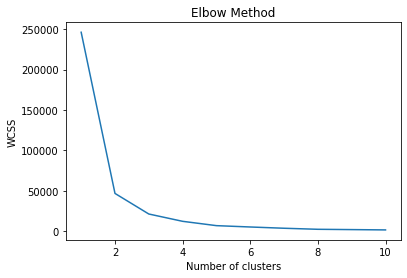

In [476]:
from matplotlib import pyplot as plt
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(ScoreDF)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [477]:
# run k-means clustering
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(ScoreDF)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [478]:
#Categoried_medical_support=toronto_venues
Categoried_medical_support = toronto_venues
Categoried_medical_support['Medical support category'] = kmeans.labels_

In [479]:
Categoried_medical_support

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Medical Center,Urgent care,Medical Lab,Medical Emergency,Hospital,Medical support category
0,"Rouge,Malvern",43.806686,-79.194353,1,1,1,1,0,0
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,0,0,0,0,0
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,3,3,4,3,1,0
3,Woburn,43.770992,-79.216917,6,6,8,7,2,0
4,Cedarbrae,43.773136,-79.239476,6,6,6,7,0,0
5,Scarborough Village,43.744734,-79.239476,4,4,6,5,2,0
6,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,0,0,0,0,0,0
7,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,1,1,1,1,0,0
8,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,0,0,0,0,0,0
9,"Birch Cliff,Cliffside West",43.692657,-79.264848,2,2,2,2,0,0


In [480]:
Categoried_medical_support['Hospital'].sum()

303

Text(0.5, 1.0, 'Statistics of Health organization in Toronto Neighbourhood')

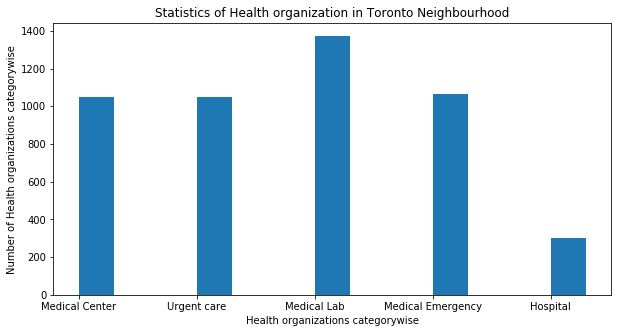

In [481]:
Medical_Center = Categoried_medical_support['Medical Center'].sum()
Urgent_care = Categoried_medical_support['Urgent care'].sum()
Medical_Lab = Categoried_medical_support['Medical Lab'].sum()
Medical_Emergency = Categoried_medical_support['Medical Emergency'].sum()
Hospital = Categoried_medical_support['Hospital'].sum()

objects = ('Medical Center', 'Urgent care','Medical Lab', 'Medical Emergency','Hospital')

performance = [Medical_Center,Urgent_care, Medical_Lab,Medical_Emergency, Hospital]

plt.figure(figsize=(10, 5))  # width:20, height:3
plt.bar(y_pos, performance, align='edge', width=0.3)

plt.xticks(y_pos, objects)
plt.ylabel('Number of Health organizations categorywise')
plt.xlabel('Health organizations categorywise')
plt.title('Statistics of Health organization in Toronto Neighbourhood')


#### Let's check how many venues were returned for each neighborhood

#### Let's find out how many unique categories can be curated from all the returned venues


## 3. Analyze Each Neighborhood

## 4. Cluster Neighborhoods

## 5. Examine Clusters

#### Cluster 1

In [482]:
#Categoried_medical_support.loc[Categoried_medical_support['Medical support category'] == 0, Categoried_medical_support.columns[[0] + list(range(3, Categoried_medical_support.shape[1]))]]
index=Categoried_medical_support['Medical support category'] == 0
Categoried_medical_support[index]
Categoried_medical_support[index].shape[0]

71

(0, 1400)

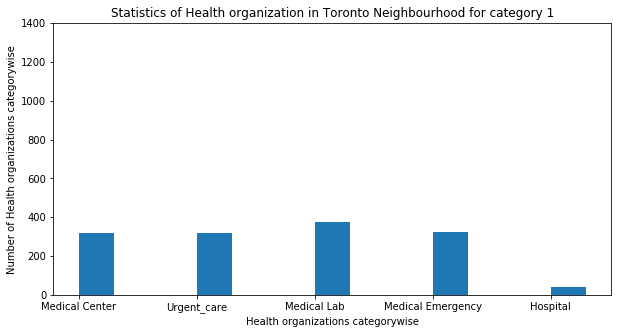

In [483]:
#Categoried_medical_support[index]
Categoried_medical_support_cat1=Categoried_medical_support[index]
Medical_Center = Categoried_medical_support_cat1['Medical Center'].sum()
Urgent_care = Categoried_medical_support_cat1['Urgent care'].sum()
Medical_Lab = Categoried_medical_support_cat1['Medical Lab'].sum()
Medical_Emergency = Categoried_medical_support_cat1['Medical Emergency'].sum()
Hospital = Categoried_medical_support_cat1['Hospital'].sum()

objects = ('Medical Center', 'Urgent_care','Medical Lab', 'Medical Emergency','Hospital')

performance = [Medical_Center, Urgent_care, Medical_Lab, Medical_Emergency, Hospital]

plt.figure(figsize=(10, 5))  # width:20, height:3
plt.bar(y_pos, performance, align='edge', width=0.3)
#plt.bar(y_pos, performance, align='center', alpha=0.5)

plt.xticks(y_pos, objects)
plt.ylabel('Number of Health organizations categorywise')
plt.xlabel('Health organizations categorywise')
plt.title('Statistics of Health organization in Toronto Neighbourhood for category 1')
plt.ylim(0, 1400)

In [484]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(Categoried_medical_support_cat1['Neighborhood Latitude'], Categoried_medical_support_cat1['Neighborhood Longitude'],  Categoried_medical_support_cat1['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto 

/Users/manashsarma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Cluster 2

In [485]:
index=Categoried_medical_support['Medical support category'] == 1
Categoried_medical_support[index]
Categoried_medical_support[index].shape[0]

17

(0, 1400)

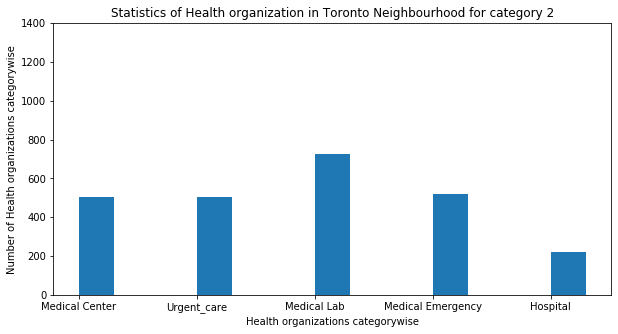

In [486]:
Categoried_medical_support_cat2=Categoried_medical_support[index]
Medical_Center = Categoried_medical_support_cat2['Medical Center'].sum()
Urgent_care = Categoried_medical_support_cat2['Urgent care'].sum()
Medical_Lab = Categoried_medical_support_cat2['Medical Lab'].sum()
Medical_Emergency = Categoried_medical_support_cat2['Medical Emergency'].sum()
Hospital = Categoried_medical_support_cat2['Hospital'].sum()

objects = ('Medical Center', 'Urgent_care','Medical Lab', 'Medical Emergency','Hospital')

performance = [Medical_Center, Urgent_care, Medical_Lab, Medical_Emergency, Hospital]

plt.figure(figsize=(10, 5))  # width:20, height:3
plt.bar(y_pos, performance, align='edge', width=0.3)
#plt.bar(y_pos, performance, align='center', alpha=0.5)

plt.xticks(y_pos, objects)
plt.ylabel('Number of Health organizations categorywise')
plt.xlabel('Health organizations categorywise')
plt.title('Statistics of Health organization in Toronto Neighbourhood for category 2')
plt.ylim(0, 1400)

In [487]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(Categoried_medical_support_cat2['Neighborhood Latitude'], Categoried_medical_support_cat2['Neighborhood Longitude'],  Categoried_medical_support_cat2['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto    

/Users/manashsarma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Cluster 3

In [488]:
index=Categoried_medical_support['Medical support category'] == 2
Categoried_medical_support[index]
Categoried_medical_support[index].shape[0]

15

(0, 1400)

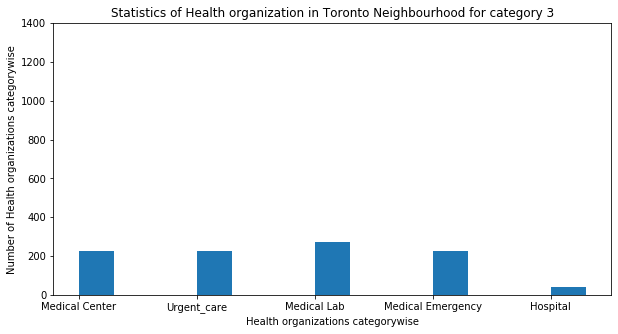

In [489]:
Categoried_medical_support_cat3=Categoried_medical_support[index]
Medical_Center = Categoried_medical_support_cat3['Medical Center'].sum()
Urgent_care = Categoried_medical_support_cat3['Urgent care'].sum()
Medical_Lab = Categoried_medical_support_cat3['Medical Lab'].sum()
Medical_Emergency = Categoried_medical_support_cat3['Medical Emergency'].sum()
Hospital = Categoried_medical_support_cat1['Hospital'].sum()

objects = ('Medical Center', 'Urgent_care','Medical Lab', 'Medical Emergency','Hospital')

performance = [Medical_Center, Urgent_care, Medical_Lab, Medical_Emergency, Hospital]

plt.figure(figsize=(10, 5))  # width:20, height:3
plt.bar(y_pos, performance, align='edge', width=0.3)
#plt.bar(y_pos, performance, align='center', alpha=0.5)

plt.xticks(y_pos, objects)
plt.ylabel('Number of Health organizations categorywise')
plt.xlabel('Health organizations categorywise')
plt.title('Statistics of Health organization in Toronto Neighbourhood for category 3')
plt.ylim(0, 1400)

In [490]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(Categoried_medical_support_cat3['Neighborhood Latitude'], Categoried_medical_support_cat3['Neighborhood Longitude'],  Categoried_medical_support_cat3['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto    

/Users/manashsarma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 43.653963, -79.387207.
